In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow.keras import regularizers

from tensorflow.keras import layers
from tensorflow.keras import losses

from collections import Counter


import pandas as pd
import numpy as np
import h5py

import sklearn

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras import preprocessing
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


import seaborn as sns

import pydot



In [2]:
print(tf.__version__)


2.1.0


In [3]:
if tf.config.list_physical_devices('GPU'): 
    print('Default GPU Device:{}'.format(tf.config.list_physical_devices('GPU')))

else:
    print("Please install GPU version of TF")

Please install GPU version of TF


In [4]:



def clean_text(text ): 
    delete_dict = {sp_character: '' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
  
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>2))]) 
    
    return text2.lower()



In [5]:
review_data= pd.read_csv(r"C:\Users\User\Desktop\TextClassificationLSTMTensorFlow-master\AMAZON_FASHION.csv")
print(review_data.head(10))
print(len(review_data))
print('Unique Products')
print(len(review_data.groupby('productID')))
print('Unique Users')
print(len(review_data.groupby('reviewerID')))

   Unnamed: 0  rating  verified   reviewTime      reviewerID   productID  \
0           0     5.0      True  10 20, 2014  A1D4G1SNUZWQOT  7106116521   
1           1     2.0      True  09 28, 2014  A3DDWDH9PX2YX2  7106116521   
2           2     4.0     False  08 25, 2014  A2MWC41EW7XL15  7106116521   
3           3     2.0      True  08 24, 2014  A2UH2QQ275NV45  7106116521   
4           4     3.0     False  07 27, 2014   A89F3LQADZBS5  7106116521   
5           5     5.0      True  07 19, 2014  A29HLOUW0NS0EH  7106116521   
6           6     4.0      True  05 31, 2014   A7QS961ROI6E0  7106116521   
7           7     3.0      True  09 22, 2013  A1BB77SEBQT8VX  B00007GDFV   
8           8     3.0      True  07 17, 2013   AHWOW7D1ABO9C  B00007GDFV   
9           9     3.0      True  04 13, 2013   AKS3GULZE0HFC  B00007GDFV   

                                          reviewText  \
0                             Exactly what I needed.   
1  I agree with the other review, the opening is ..

In [6]:
review_data.dropna(axis = 0, how ='any',inplace=True) 






review_data['reviewText'] = review_data['reviewText'].apply(clean_text)
review_data['Num_words_text'] = review_data['reviewText'].apply(lambda x:len(str(x).split())) 

print('-------Dataset --------')
print(review_data['rating'].value_counts())
print(len(review_data))
print('-------------------------')
max_review_data_sentence_length  = review_data['Num_words_text'].max()

print('Train Max Sentence Length :'+str(max_review_data_sentence_length))





-------Dataset --------
5.0    389023
4.0    134842
1.0     99496
3.0     90633
2.0     61078
Name: rating, dtype: int64
775072
-------------------------
Train Max Sentence Length :1602


In [7]:
review_data['Num_words_text'].describe()

count    775072.000000
mean         23.499742
std          29.454636
min           0.000000
25%           7.000000
50%          15.000000
75%          28.000000
max        1602.000000
Name: Num_words_text, dtype: float64

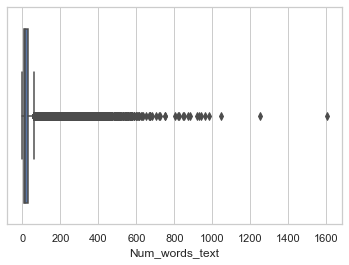

In [8]:
sns.set(style="whitegrid")
sns.boxplot(x=review_data['Num_words_text'])

In [9]:
mask = (review_data['Num_words_text'] < 100) & (review_data['Num_words_text'] >=20)
df_short_reviews = review_data[mask]
print('No of Short reviews')
print(len(df_short_reviews))

mask = review_data['Num_words_text'] >= 100
df_long_reviews = review_data[mask]
print('No of Long reviews')
print(len(df_long_reviews))

No of Short reviews
281480
No of Long reviews
19233


In [10]:
print(df_short_reviews['Num_words_text'].max())

99


In [11]:
def get_sentiment(rating):
    if rating == 5 or rating == 4 or rating ==3:
        return 1
    else:
        return 0
    

In [12]:

filtered_data = df_short_reviews.groupby('productID').filter(lambda x: len(x) >= 20)
print(len(filtered_data))
print(filtered_data ['rating'].value_counts())
filtered_data ['sentiment'] = filtered_data ['rating'].apply(get_sentiment)

train_data = filtered_data[['reviewText','sentiment']]
print('Train data')
print(train_data['sentiment'].value_counts())


mask = review_data['Num_words_text'] < 100 
df_short_reviews = review_data[mask]
filtered_data = df_short_reviews.groupby('productID').filter(lambda x: len(x) >= 10)
print(len(filtered_data))
print(filtered_data ['rating'].value_counts())
filtered_data ['sentiment'] = filtered_data ['rating'].apply(get_sentiment)

test_data = filtered_data[['reviewText','sentiment']]
print('Test data')
print(test_data['sentiment'].value_counts())




94768
5.0    47104
4.0    19132
3.0    11596
1.0     9406
2.0     7530
Name: rating, dtype: int64
Train data
1    77832
0    16936
Name: sentiment, dtype: int64
433782
5.0    225104
4.0     75616
1.0     51790
3.0     48706
2.0     32566
Name: rating, dtype: int64
Test data
1    349426
0     84356
Name: sentiment, dtype: int64


In [13]:
train_data['sentiment'].value_counts()

1    77832
0    16936
Name: sentiment, dtype: int64

In [14]:
X_train, X_valid, y_train, y_valid = train_test_split(train_data['reviewText'].tolist(),\
                                                      train_data['sentiment'].tolist(),\
                                                      test_size=0.5,\
                                                      stratify = train_data['sentiment'].tolist(),\
                                                      random_state=0)


print('Train data len:'+str(len(X_train)))
print('Class distribution'+str(Counter(y_train)))
print('Valid data len:'+str(len(X_valid)))
print('Class distribution'+ str(Counter(y_valid)))

Train data len:47384
Class distributionCounter({1: 38916, 0: 8468})
Valid data len:47384
Class distributionCounter({1: 38916, 0: 8468})


In [15]:
num_words = 50000

tokenizer = Tokenizer(num_words=num_words,oov_token="unk")
tokenizer.fit_on_texts(X_train)


print(str(tokenizer.texts_to_sequences(['xyz how are you'])))

   


[[26099, 111, 11, 18]]


In [16]:



x_train = np.array( tokenizer.texts_to_sequences(X_train) )
x_valid = np.array( tokenizer.texts_to_sequences(X_valid) )
x_test  = np.array( tokenizer.texts_to_sequences(test_data['reviewText'].tolist()) )



x_train = pad_sequences(x_train, padding='post', maxlen=100)
x_valid = pad_sequences(x_valid, padding='post', maxlen=100)
x_test = pad_sequences(x_test, padding='post', maxlen=100)



train_labels = np.asarray(y_train )
valid_labels = np.asarray( y_valid)

test_labels = np.asarray(test_data['sentiment'].tolist())

print('Train data len:'+str(len(x_train)))
print('Class distribution'+str(Counter(train_labels)))

print('Validation data len:'+str(len(x_valid)))
print('Class distribution'+str(Counter(valid_labels)))

print('Test data len:'+str(len(x_test)))
print('Class distribution'+str(Counter(test_labels)))


train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid,valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_labels))


C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.
C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must 

Train data len:47384
Class distributionCounter({1: 38916, 0: 8468})
Validation data len:47384
Class distributionCounter({1: 38916, 0: 8468})
Test data len:433782
Class distributionCounter({1: 349426, 0: 84356})


In [17]:
count =0
print('======Train dataset ====')
for value,label in train_ds:
    count += 1
    print(value,label)
    if count==1:
        break
count =0
print('======Validation dataset ====')
for value,label in valid_ds:
    count += 1
    print(value,label)
    if count==1:
        break
count =0
print('======Test dataset ====')
for value,label in test_ds:
    count += 1
    print(value,label)
    if count==1:
        break  

======Train dataset ====
tf.Tensor(
[ 110   97   15  322  116  170  103   52  217    8   36  210  172 4619
 3581    3 2038   62  224 1343 1378    3  503  299  782   30  106   77
  123    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0], shape=(100,), dtype=int32) tf.Tensor(1, shape=(), dtype=int32)
======Validation dataset ====
tf.Tensor(
[  22   65 4061    4  562  189   14   46   70  901   54   22    3   58
   22   25   43  331   99  153   82    3  643   15   11 1215 2888    4
  134 1430    8  286    9   76  900   67   22   77   13  217    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

In [18]:
max_features =50000
embedding_dim =16
sequence_length = 100

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_features +1, embedding_dim, input_length=sequence_length,\
                                    embeddings_regularizer = regularizers.l2(0.005))) 
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.LSTM(embedding_dim,dropout=0.2, recurrent_dropout=0.2,return_sequences=True,\
                                                             kernel_regularizer=regularizers.l2(0.005),\
                                                             bias_regularizer=regularizers.l2(0.005)))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(512, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Dense(8, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
model.add(tf.keras.layers.Dropout(0.4))


model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
                               



model.summary()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer=tf.keras.optimizers.Adam(1e-3),metrics=[tf.keras.metrics.BinaryAccuracy()])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           800016    
_________________________________________________________________
dropout (Dropout)            (None, 100, 16)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 100, 16)           2112      
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               819712    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 4

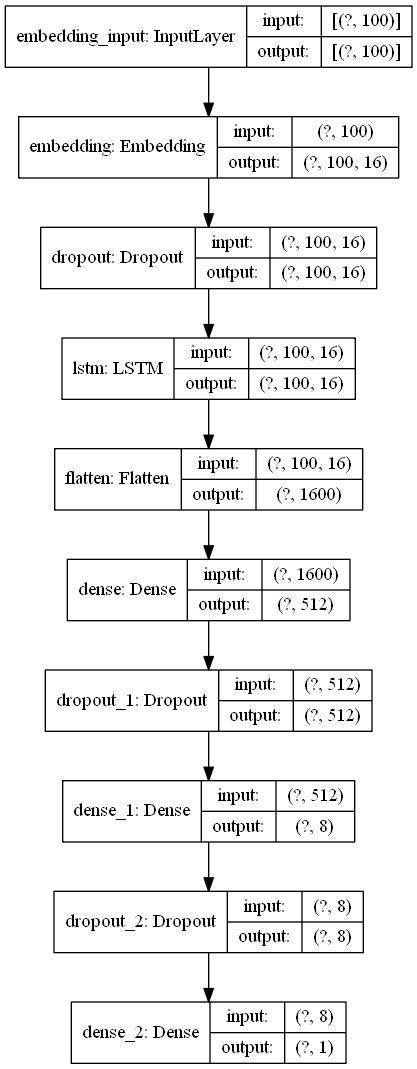

In [19]:
tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [20]:
epochs = 10

history = model.fit(train_ds.shuffle(5000).batch(1024),
                    epochs= epochs ,
                    validation_data=valid_ds.batch(1024),
                    verbose=1)

Train for 47 steps, validate for 47 steps
Epoch 1/10


C:\Users\User\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\User\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


47/47 [==============================] - 19s 410ms/step - loss: 1.9973 - binary_accuracy: 0.8156 - val_loss: 0.6757 - val_binary_accuracy: 0.8213
Epoch 2/10
47/47 [==============================] - 16s 331ms/step - loss: 0.5689 - binary_accuracy: 0.8451 - val_loss: 0.4556 - val_binary_accuracy: 0.8823
Epoch 3/10
47/47 [==============================] - 16s 334ms/step - loss: 0.4728 - binary_accuracy: 0.8789 - val_loss: 0.4197 - val_binary_accuracy: 0.8907
Epoch 4/10
47/47 [==============================] - 17s 362ms/step - loss: 0.4388 - binary_accuracy: 0.8857 - val_loss: 0.3978 - val_binary_accuracy: 0.8935
Epoch 5/10
47/47 [==============================] - 17s 368ms/step - loss: 0.4173 - binary_accuracy: 0.8902 - val_loss: 0.3858 - val_binary_accuracy: 0.8932
Epoch 6/10
47/47 [==============================] - 17s 367ms/step - loss: 0.4063 - binary_accuracy: 0.8903 - val_loss: 0.3781 - val_binary_accuracy: 0.8925
Epoch 7/10
47/47 [==============================] - 17s 371ms/step - 

In [21]:
history.history


{'loss': [2.016962261492188,
  0.5701498828303788,
  0.473749247154593,
  0.43902950564208476,
  0.41798973840252684,
  0.40743930224488356,
  0.392567040080781,
  0.38685472337514915,
  0.3772741611163278,
  0.3729650419184672],
 'binary_accuracy': [0.81557065,
  0.8451165,
  0.8788832,
  0.8856787,
  0.8902161,
  0.8902794,
  0.8902372,
  0.8897096,
  0.89310735,
  0.8927275],
 'val_loss': [0.6756818903253433,
  0.4556102131275421,
  0.4197473684523968,
  0.3978485173367439,
  0.3857804720706128,
  0.3780680520737425,
  0.3694925117999949,
  0.3607690993775713,
  0.35428157258541026,
  0.35212775113734796],
 'val_binary_accuracy': [0.8212899,
  0.88232315,
  0.8906804,
  0.8935295,
  0.8932129,
  0.89247423,
  0.89388824,
  0.895661,
  0.89612526,
  0.8950279]}

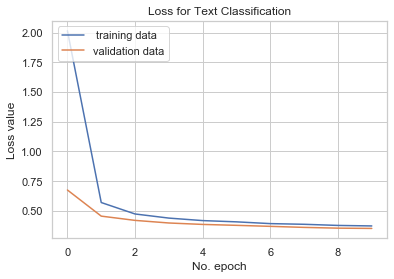

In [22]:

plt.plot(history.history['loss'], label=' training data')
plt.plot(history.history['val_loss'], label='validation data')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

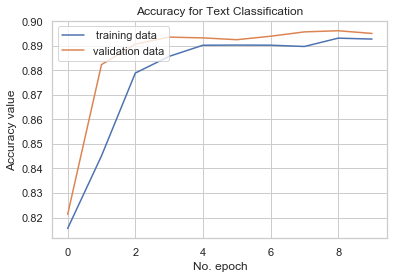

In [23]:


plt.plot(history.history['binary_accuracy'], label=' training data')
plt.plot(history.history['val_binary_accuracy'], label='validation data')
plt.title('Accuracy for Text Classification')
plt.ylabel('Accuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()


In [24]:
model.save("tf_lstmmodel.h5") 
json_string = tokenizer.to_json()


In [25]:
import json
with open('tokenizer.json', 'w') as outfile:
    json.dump(json_string, outfile)
    

In [26]:
valid_predict= model.predict(x_valid)

In [27]:
print(valid_predict[:10])

[[0.99811196]
 [0.38557202]
 [0.97142076]
 [0.9321328 ]
 [0.44591576]
 [0.74743897]
 [0.9997404 ]
 [0.98170197]
 [0.98448354]
 [0.9746494 ]]


In [28]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, thresholds = sklearn.metrics.roc_curve(labels, predictions)
    plt.plot(fp, tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives Rate')
    plt.ylabel('True positives Rate')
    plt.xlim([-0.03, 1.0])
    plt.ylim([0.0, 1.03])
    plt.grid(True)
    thresholdsLength = len(thresholds)
    thresholds_every = 1000
    colorMap = plt.get_cmap('jet', thresholdsLength)
    for i in range(0, thresholdsLength, thresholds_every):
        threshold_value_with_max_four_decimals = str(thresholds[i])[:5]
        plt.text(fp[i] - 0.03, tp[i] + 0.001, threshold_value_with_max_four_decimals, fontdict={'size': 15}, color=colorMap(i/thresholdsLength));

    ax = plt.gca()
    ax.set_aspect('equal')

In [29]:
mpl.rcParams['figure.figsize'] = (16, 16)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

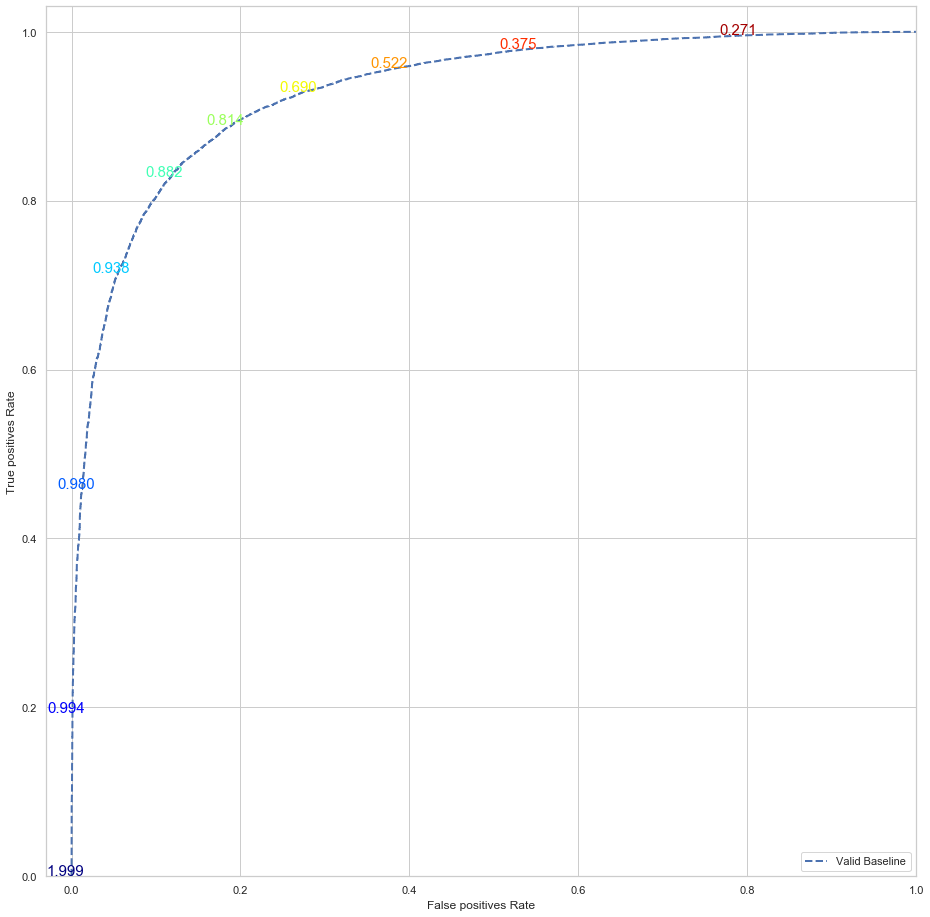

In [30]:
plot_roc("Valid Baseline", valid_labels, valid_predict, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [31]:
with open('tokenizer.json') as json_file:
    json_string = json.load(json_file)
tokenizer1 = tf.keras.preprocessing.text.tokenizer_from_json(json_string)

In [32]:
x_test  = np.array( tokenizer.texts_to_sequences(test_data['reviewText'].tolist()) )
x_test = pad_sequences(x_test, padding='post', maxlen=100)

C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [33]:


print("Generate predictions for all samples")
predictions = model.predict(x_test)



Generate predictions for all samples


In [34]:
test_data['pred_sentiment']= predictions
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment >= 0.78),1,test_data.pred_sentiment)
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment < 0.78),0,test_data.pred_sentiment)


C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [39]:
labels = [0, 1]
    
print(classification_report(test_data['sentiment'].tolist(),test_data['pred_sentiment'].tolist(),labels=labels))

              precision    recall  f1-score   support

           0       0.69      0.80      0.74     84356
           1       0.95      0.91      0.93    349426

    accuracy                           0.89    433782
   macro avg       0.82      0.85      0.84    433782
weighted avg       0.90      0.89      0.89    433782



In [18]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.model_selection import cross_val_score

model1 = svm.SVC(kernel='linear',random_state= 42)
model1.fit(x_train[:200],train_labels[:200])
y_pred = model1.predict(x_valid[:200])
print(y_pred)


confusion_matrix(valid_labels[:200],y_pred)
                 

print("Accuracy:",metrics.accuracy_score(valid_labels[:200],y_pred))

[0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 0 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 0 1
 1 1 1 1 0 1 1 1 0 1 0 1 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1
 1 1 1 1 1 1 0 0 1 0 1 1 0 1 0 1 1 0 1 1 1 1 0 0 0 1 1 0 0 1 1 1 1 1 0 1 1
 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1
 1 0 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1]
Accuracy: 0.66
